In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import os
import re
import warnings
import json


warnings.filterwarnings('ignore')

SAVE_DIR = os.path.join("..", "..","CHART", "DLINEAR+NODE")
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Thư mục lưu biểu đồ: {SAVE_DIR}")

# Cấu hình thiết bị
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Siêu tham số
SEQ_LEN = 60
HIDDEN_DIM = 128
DROPOUT = 0.2
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001



PRICE_DIR = os.path.join("..", "..", "DATASET", "PRICE")
LOG_DIR = os.path.join("..", "..", "LOGS", "DLINEAR+NODE")
os.makedirs(LOG_DIR, exist_ok=True)

Thư mục lưu biểu đồ: ..\..\CHART\DLINEAR+NODE
Using device: cpu


In [28]:
class HybridDLinearNodeModel(nn.Module):
    """Hybrid DLinear + NODE model với price + residual (Phiên bản đầy đủ)"""
    def __init__(self, seq_len=60, price_dim=5, residual_dim=5, hidden_dim=128, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.price_dim = price_dim
        self.residual_dim = residual_dim
        
        # DLinear trend decomposition cho Price
        self.trend_dlinear = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        # DLinear decomposition cho Residuals
        self.residual_dlinear = nn.Sequential(
            nn.Linear(seq_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len)
        )
        
        # NODE (Neural ODE) component để học động lực học phi tuyến
        self.node_func = nn.Sequential(
            nn.Linear(price_dim + residual_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, price_dim + residual_dim)
        )
        
        # Feature fusion layers
        self.fusion = nn.Sequential(
            nn.Linear((price_dim + residual_dim) * seq_len, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Predictor cuối cùng
        self.predictor = nn.Linear(hidden_dim // 2, 1)
        
    def forward(self, price_x, residual_x):
        batch_size, seq_len, _ = price_x.shape
        
        # Kết hợp Price và Residual data
        combined_input = torch.cat([price_x, residual_x], dim=-1)
        
        # Trích xuất xu hướng (Trend) bằng DLinear
        price_trend = self.trend_dlinear(price_x.transpose(1, 2)).transpose(1, 2)
        residual_processed = self.residual_dlinear(residual_x.transpose(1, 2)).transpose(1, 2)
        
        dlinear_output = torch.cat([price_trend, residual_processed], dim=-1)
        
        # Tính toán động lực học qua khối NODE (Residual connection)
        node_output = combined_input + self.node_func(combined_input)
        
        # Cộng hưởng Hybrid: DLinear + NODE
        hybrid_features = dlinear_output + node_output
        
        # Flatten và Fusion
        flattened = hybrid_features.reshape(batch_size, -1)
        fused = self.fusion(flattened)
        output = self.predictor(fused)
        
        return output

In [29]:
# --- CẬP NHẬT TRONG CELL 3 ---

class HybridDataProcessor:
    def __init__(self):
        self.scalers = {
            'price': StandardScaler(),
            'res': StandardScaler(),
            'target': StandardScaler()
        }
        
    def load_clean_data(self, file_path):
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        
        # Tự động đồng bộ tên cột từ Tiếng Anh sang Tiếng Việt chuẩn của code
        column_mapping = {
            'Date': 'Ngày', 'Time': 'Ngày', 'date': 'Ngày',
            'Close': 'Lần cuối', 'Price': 'Lần cuối', 'Last': 'Lần cuối',
            'Open': 'Mở', 'High': 'Cao', 'Low': 'Thấp',
            'Vol': 'KL', 'Volume': 'KL', 'Khối lượng': 'KL'
        }
        df.columns = [column_mapping.get(c, c) for c in df.columns]
        
        # Xử lý cột Ngày
        if 'Ngày' not in df.columns:
            raise KeyError(f"Không tìm thấy cột ngày tháng trong {file_path}")
        df['Ngày'] = pd.to_datetime(df['Ngày'], dayfirst=True, errors='coerce')
        df = df.dropna(subset=['Ngày']).sort_values('Ngày')
        
        # Làm sạch các cột số
        price_cols = ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'KL']
        for col in price_cols:
            if col in df.columns:
                if df[col].dtype == 'object':
                    df[col] = df[col].astype(str).str.replace(',', '').str.replace('M', 'e6').str.replace('K', 'e3')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Điền dữ liệu trống để tránh lỗi Tensor
        df[price_cols] = df[price_cols].ffill().bfill()
        
        price_data = df[price_cols].values
        # Tính Residual (Giá - SMA 20)
        res_data = price_data - pd.DataFrame(price_data).rolling(window=20, min_periods=1).mean().values
        
        return df['Ngày'].values, price_data, res_data, df['Lần cuối'].values

    def prepare_sequences(self, dates, p_data, r_data, target, seq_len=60):
        p_scaled = self.scalers['price'].fit_transform(p_data)
        r_scaled = self.scalers['res'].fit_transform(r_data)
        t_scaled = self.scalers['target'].fit_transform(target.reshape(-1, 1)).flatten()
        
        X_p, X_r, Y, Y_dates = [], [], [], []
        for i in range(seq_len, len(t_scaled)):
            X_p.append(p_scaled[i-seq_len:i])
            X_r.append(r_scaled[i-seq_len:i])
            Y.append(t_scaled[i])
            Y_dates.append(dates[i])
            
        return np.array(X_p), np.array(X_r), np.array(Y), np.array(Y_dates)

def get_valid_ticker_files(directory):

    all_files = os.listdir(directory)
    # Chỉnh sửa regex để nhận diện cả chữ hoa và chữ thường (ví dụ: Google.csv, VNM.csv)
    # Loại bỏ các file có hậu tố dài như _stock_data
    pattern = re.compile(r'^[A-Za-z]+\.csv$')
    valid_files = [f for f in all_files if pattern.match(f)]
    return valid_files

In [30]:

def train_and_evaluate(stock_name):
    # --- 0. DINH NGHIA DUONG DAN O NGOAI (ROOT) ---
    # Dung os.path.join de dam bao chay dung tren ca Windows/Linux
    CHART_DIR = os.path.join("..", "..", "CHART", "DLINEAR+NODE")
    LOG_DIR = os.path.join("..", "..", "LOGS", "DLINEAR+NODE")
    
    # Tao thu muc neu chua ton tai
    os.makedirs(CHART_DIR, exist_ok=True)
    os.makedirs(LOG_DIR, exist_ok=True)

    # --- 1. LOAD VA CHUAN BI DU LIEU ---
    processor = HybridDataProcessor()
    file_path = os.path.join(PRICE_DIR, f"{stock_name}.csv")
    
    if not os.path.exists(file_path):
        print(f"Khong tim thay file: {file_path}")
        return

    dates, p_data, r_data, targets = processor.load_clean_data(file_path)
    X_p, X_r, Y, Y_dates = processor.prepare_sequences(dates, p_data, r_data, targets, SEQ_LEN)
    
    split = int(len(Y) * 0.8)
    train_p, test_p = torch.FloatTensor(X_p[:split]), torch.FloatTensor(X_p[split:])
    train_r, test_r = torch.FloatTensor(X_r[:split]), torch.FloatTensor(X_r[split:])
    train_y, test_y = torch.FloatTensor(Y[:split]), torch.FloatTensor(Y[split:])
    test_dates = Y_dates[split:] 
    
    train_loader = DataLoader(TensorDataset(train_p, train_r, train_y), batch_size=BATCH_SIZE, shuffle=True)
    
    # --- 2. KHOI TAO MO HINH ---
    model = HybridDLinearNodeModel(price_dim=X_p.shape[2], residual_dim=X_r.shape[2]).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    history = {"train_loss": []}
    
    # --- 3. HUAN LUYEN ---
    print(f"\nDang huan luyen ma: {stock_name}")
    for epoch in range(1, EPOCHS + 1):
        model.train()
        total_loss = 0
        for p, r, y in train_loader:
            p, r, y = p.to(DEVICE), r.to(DEVICE), y.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            output = model(p, r)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_loss)
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"   Epoch [{epoch:3d}/{EPOCHS}] - Loss: {avg_loss:.6f}")

    # --- 4. LUU MODEL (.pt) VA LOG (.json) VAO LOGS/Dlinear+node ---
    model_path = os.path.join(LOG_DIR, f"{stock_name}_Hybrid.pt")
    history_path = os.path.join(LOG_DIR, f"{stock_name}_Hybrid.json")
    
    torch.save(model.state_dict(), model_path)
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=4)
    print(f"Da luu Model va History vao: {LOG_DIR}")

    # --- 5. DU BAO ---
    model.eval()
    with torch.no_grad():
        preds_scaled = model(test_p.to(DEVICE), test_r.to(DEVICE)).cpu().numpy()
        preds = processor.scalers['target'].inverse_transform(preds_scaled).flatten()
        actual = processor.scalers['target'].inverse_transform(test_y.reshape(-1, 1)).flatten()
    
    # --- 6. VE BIEU DO VA LUU VAO CHART/DLINEAR+NODE ---
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, actual, label='Gia thuc te', color='#1f77b4')
    plt.plot(test_dates, preds, label='Du bao Hybrid', color='#ff7f0e', linestyle='--')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    
    plt.title(f"Ket qua du bao Model Hybrid: {stock_name}")
    plt.xlabel("Ngay thang")
    plt.ylabel("Gia co phieu")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Luu file [ticker]_Hybrid.png
    chart_path = os.path.join(CHART_DIR, f"{stock_name}_Hybrid.png")
    plt.savefig(chart_path)
    print(f"Da luu bieu do vao: {chart_path}")

    plt.show()
    plt.close()

    print(f"Hoan thanh {stock_name}. R2 Score: {r2_score(actual, preds):.4f}")

Danh sách file hợp lệ phát hiện: ['Alibaba.csv', 'Amazon.csv', 'Apple.csv', 'Google.csv', 'META.csv', 'VNM.csv']

----------------------------------------
ĐANG XỬ LÝ MÃ: Alibaba
----------------------------------------



Dang huan luyen ma: Alibaba
   Epoch [  1/150] - Loss: 0.107752
   Epoch [ 10/150] - Loss: 0.028346
   Epoch [ 20/150] - Loss: 0.024699
   Epoch [ 30/150] - Loss: 0.029713
   Epoch [ 40/150] - Loss: 0.023038
   Epoch [ 50/150] - Loss: 0.019729
   Epoch [ 60/150] - Loss: 0.018323
   Epoch [ 70/150] - Loss: 0.017442
   Epoch [ 80/150] - Loss: 0.019043
   Epoch [ 90/150] - Loss: 0.018136
   Epoch [100/150] - Loss: 0.017093
   Epoch [110/150] - Loss: 0.018815
   Epoch [120/150] - Loss: 0.016497
   Epoch [130/150] - Loss: 0.016813
   Epoch [140/150] - Loss: 0.017801
   Epoch [150/150] - Loss: 0.015190
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\Alibaba_Hybrid.png


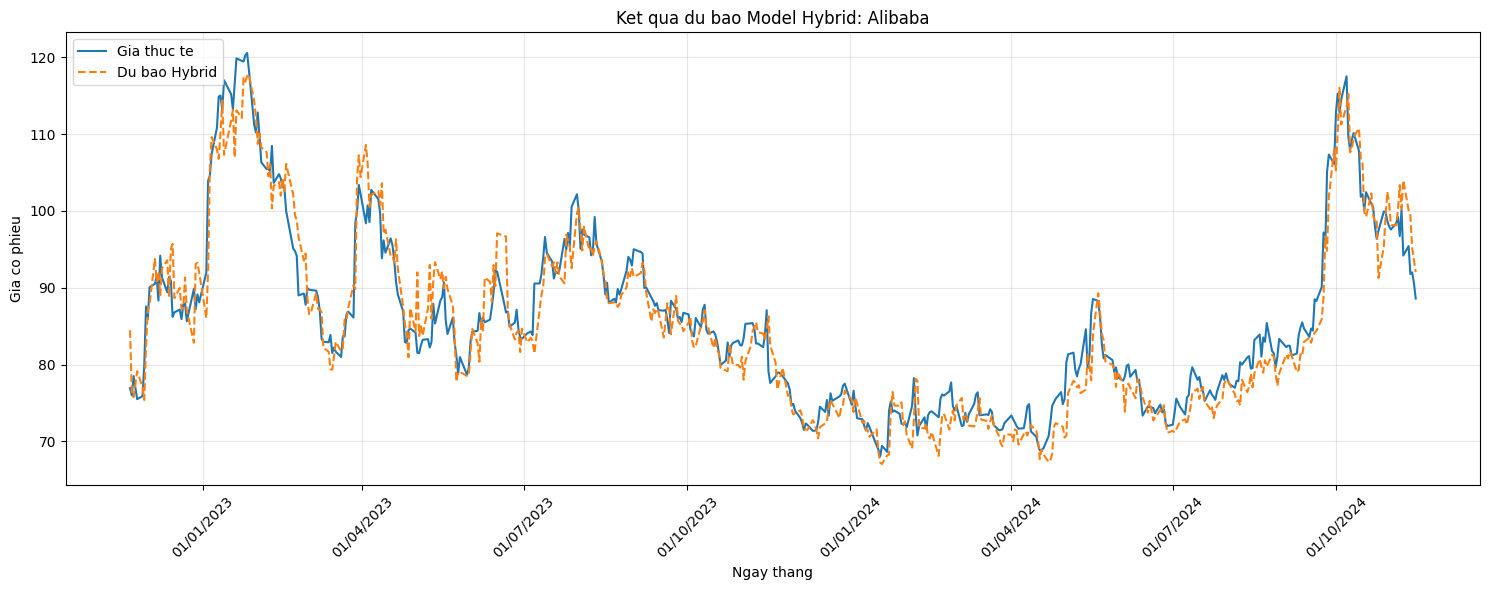

Hoan thanh Alibaba. R2 Score: 0.9113
Hoàn thành xử lý mã: Alibaba

----------------------------------------
ĐANG XỬ LÝ MÃ: Amazon
----------------------------------------

Dang huan luyen ma: Amazon
   Epoch [  1/150] - Loss: 0.137961
   Epoch [ 10/150] - Loss: 0.007226
   Epoch [ 20/150] - Loss: 0.005765
   Epoch [ 30/150] - Loss: 0.006483
   Epoch [ 40/150] - Loss: 0.004835
   Epoch [ 50/150] - Loss: 0.005198
   Epoch [ 60/150] - Loss: 0.005546
   Epoch [ 70/150] - Loss: 0.003451
   Epoch [ 80/150] - Loss: 0.003361
   Epoch [ 90/150] - Loss: 0.005916
   Epoch [100/150] - Loss: 0.002746
   Epoch [110/150] - Loss: 0.004131
   Epoch [120/150] - Loss: 0.002884
   Epoch [130/150] - Loss: 0.002061
   Epoch [140/150] - Loss: 0.003718
   Epoch [150/150] - Loss: 0.005603
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\Amazon_Hybrid.png


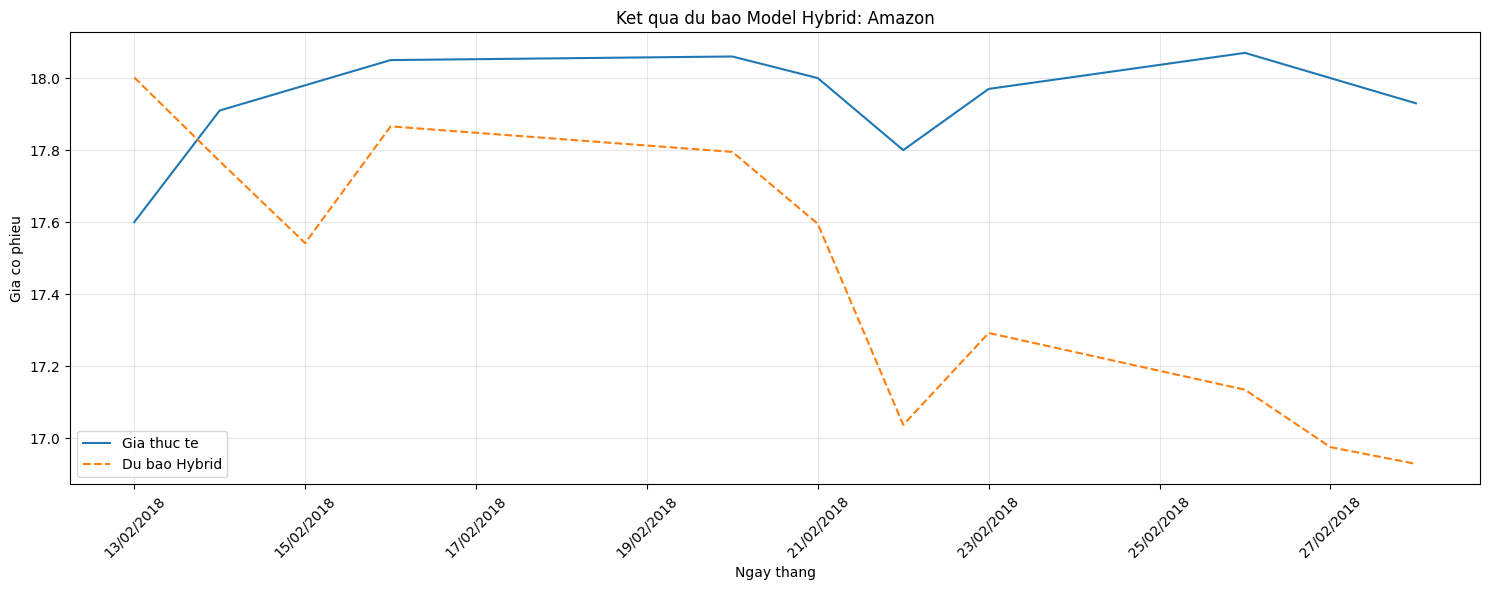

Hoan thanh Amazon. R2 Score: -23.3590
Hoàn thành xử lý mã: Amazon

----------------------------------------
ĐANG XỬ LÝ MÃ: Apple
----------------------------------------

Dang huan luyen ma: Apple
   Epoch [  1/150] - Loss: 0.142571
   Epoch [ 10/150] - Loss: 0.025307
   Epoch [ 20/150] - Loss: 0.016217
   Epoch [ 30/150] - Loss: 0.015387
   Epoch [ 40/150] - Loss: 0.014484
   Epoch [ 50/150] - Loss: 0.012749
   Epoch [ 60/150] - Loss: 0.011847
   Epoch [ 70/150] - Loss: 0.012703
   Epoch [ 80/150] - Loss: 0.010910
   Epoch [ 90/150] - Loss: 0.009818
   Epoch [100/150] - Loss: 0.011405
   Epoch [110/150] - Loss: 0.010014
   Epoch [120/150] - Loss: 0.009659
   Epoch [130/150] - Loss: 0.009935
   Epoch [140/150] - Loss: 0.008455
   Epoch [150/150] - Loss: 0.009587
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\Apple_Hybrid.png


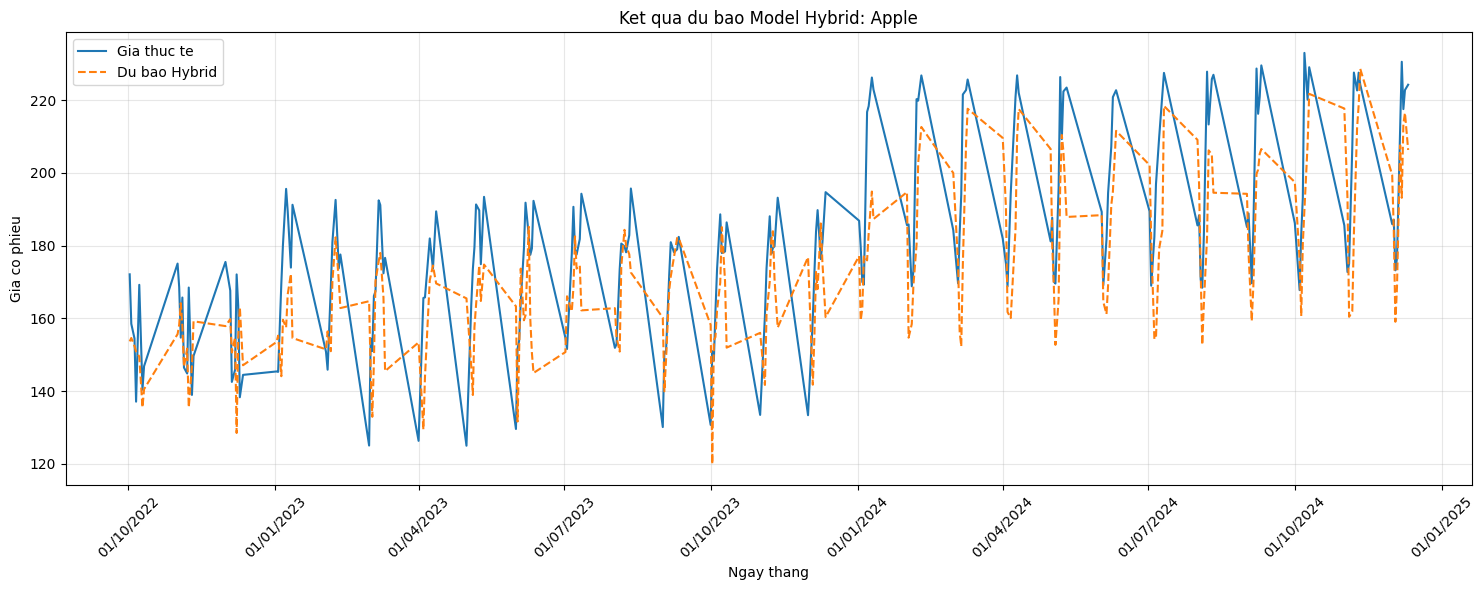

Hoan thanh Apple. R2 Score: 0.3400
Hoàn thành xử lý mã: Apple

----------------------------------------
ĐANG XỬ LÝ MÃ: Google
----------------------------------------

Dang huan luyen ma: Google
   Epoch [  1/150] - Loss: 0.166211
   Epoch [ 10/150] - Loss: 0.028949
   Epoch [ 20/150] - Loss: 0.024859
   Epoch [ 30/150] - Loss: 0.021764
   Epoch [ 40/150] - Loss: 0.016017
   Epoch [ 50/150] - Loss: 0.020080
   Epoch [ 60/150] - Loss: 0.019162
   Epoch [ 70/150] - Loss: 0.017438
   Epoch [ 80/150] - Loss: 0.013061
   Epoch [ 90/150] - Loss: 0.012993
   Epoch [100/150] - Loss: 0.013630
   Epoch [110/150] - Loss: 0.013936
   Epoch [120/150] - Loss: 0.015033
   Epoch [130/150] - Loss: 0.013128
   Epoch [140/150] - Loss: 0.012014
   Epoch [150/150] - Loss: 0.014829
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\Google_Hybrid.png


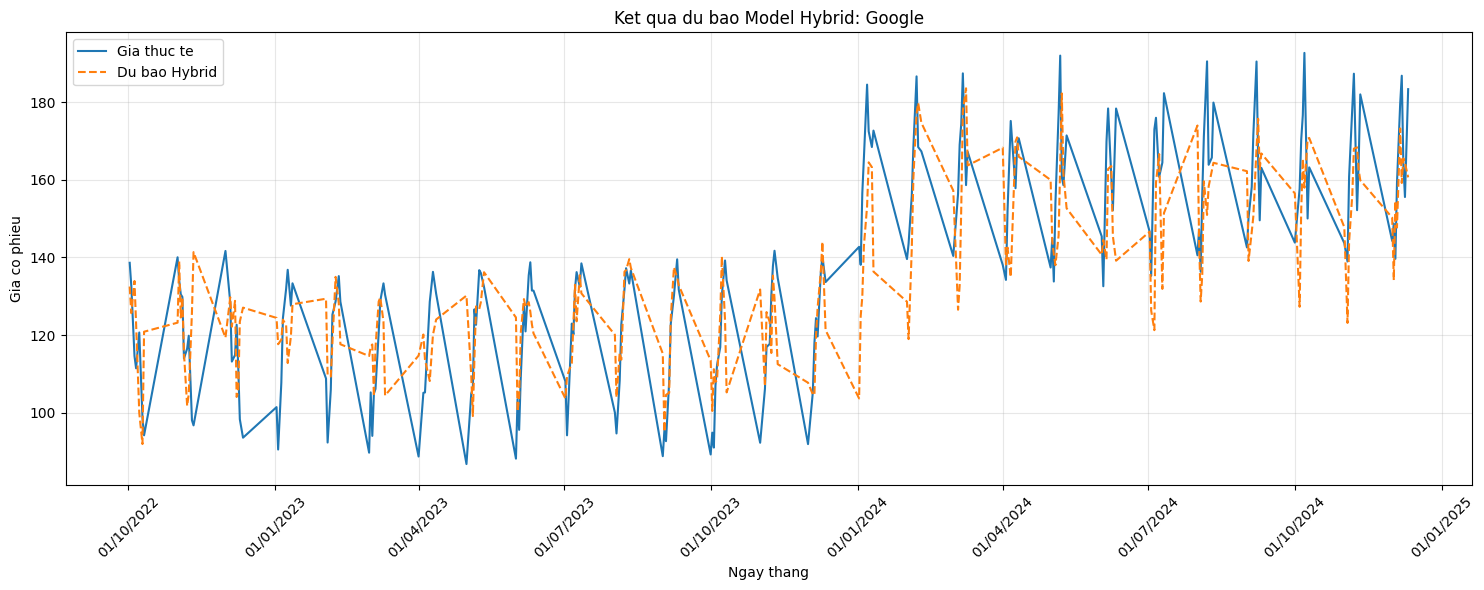

Hoan thanh Google. R2 Score: 0.5878
Hoàn thành xử lý mã: Google

----------------------------------------
ĐANG XỬ LÝ MÃ: META
----------------------------------------

Dang huan luyen ma: META
   Epoch [  1/150] - Loss: 0.030594
   Epoch [ 10/150] - Loss: 0.007816
   Epoch [ 20/150] - Loss: 0.005779
   Epoch [ 30/150] - Loss: 0.004534
   Epoch [ 40/150] - Loss: 0.005198
   Epoch [ 50/150] - Loss: 0.004284
   Epoch [ 60/150] - Loss: 0.004175
   Epoch [ 70/150] - Loss: 0.004869
   Epoch [ 80/150] - Loss: 0.004171
   Epoch [ 90/150] - Loss: 0.004541
   Epoch [100/150] - Loss: 0.004075
   Epoch [110/150] - Loss: 0.003990
   Epoch [120/150] - Loss: 0.005381
   Epoch [130/150] - Loss: 0.003950
   Epoch [140/150] - Loss: 0.004129
   Epoch [150/150] - Loss: 0.003662
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\META_Hybrid.png


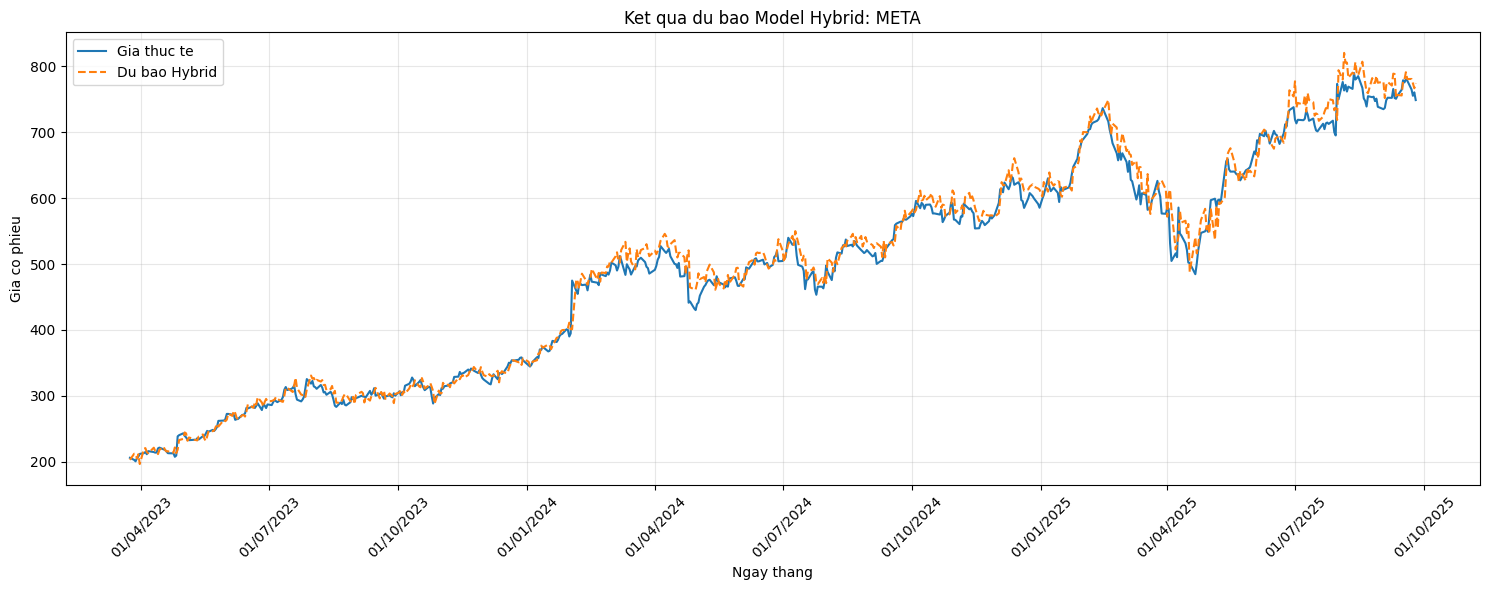

Hoan thanh META. R2 Score: 0.9866
Hoàn thành xử lý mã: META

----------------------------------------
ĐANG XỬ LÝ MÃ: VNM
----------------------------------------

Dang huan luyen ma: VNM
   Epoch [  1/150] - Loss: 0.396054
   Epoch [ 10/150] - Loss: 0.085358
   Epoch [ 20/150] - Loss: 0.050476
   Epoch [ 30/150] - Loss: 0.035572
   Epoch [ 40/150] - Loss: 0.030888
   Epoch [ 50/150] - Loss: 0.031935
   Epoch [ 60/150] - Loss: 0.026740
   Epoch [ 70/150] - Loss: 0.024654
   Epoch [ 80/150] - Loss: 0.022167
   Epoch [ 90/150] - Loss: 0.023031
   Epoch [100/150] - Loss: 0.028505
   Epoch [110/150] - Loss: 0.027173
   Epoch [120/150] - Loss: 0.023374
   Epoch [130/150] - Loss: 0.021087
   Epoch [140/150] - Loss: 0.025089
   Epoch [150/150] - Loss: 0.019899
Da luu Model va History vao: ..\..\LOGS\DLINEAR+NODE
Da luu bieu do vao: ..\..\CHART\DLINEAR+NODE\VNM_Hybrid.png


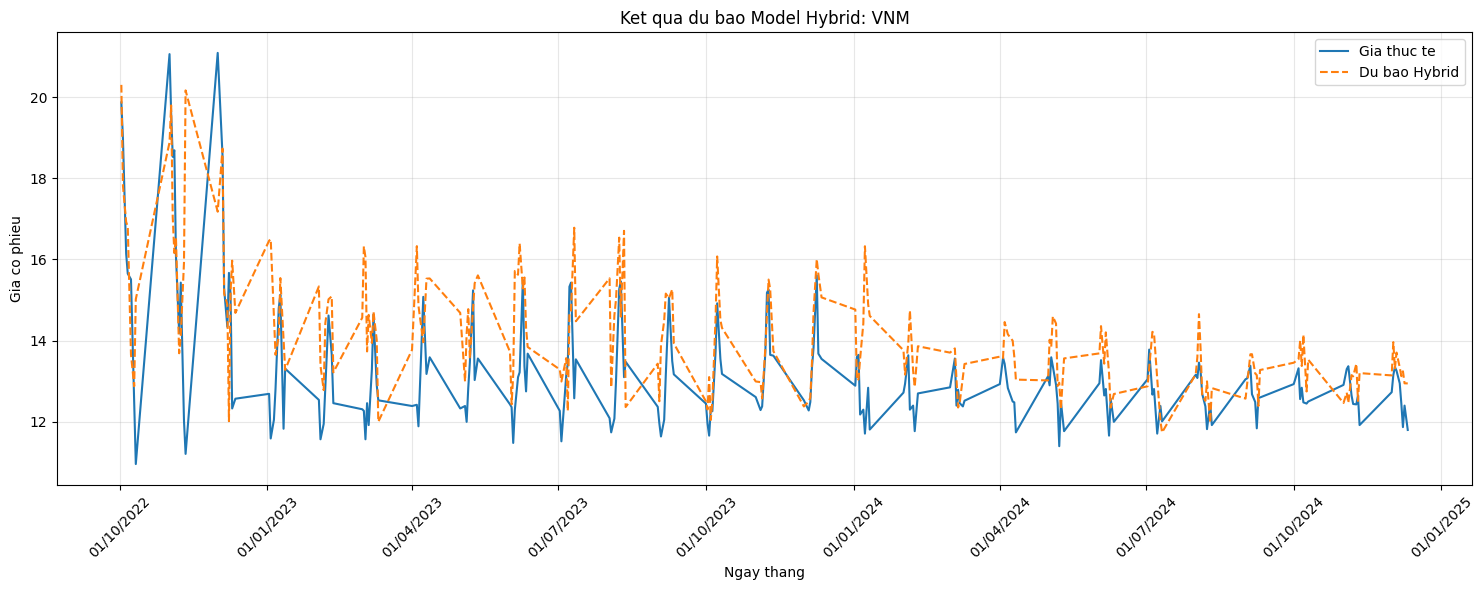

Hoan thanh VNM. R2 Score: -0.0972
Hoàn thành xử lý mã: VNM

ĐÃ HOÀN THÀNH XỬ LÝ TOÀN BỘ DANH SÁCH.


In [31]:
# --- CELL 5: THỰC THI TOÀN BỘ DANH SÁCH ---

valid_files = get_valid_ticker_files(PRICE_DIR)
print(f"Danh sách file hợp lệ phát hiện: {valid_files}")

if not valid_files:
    print(f"Không tìm thấy file đúng định dạng [TICKER].csv trong {PRICE_DIR}")
else:
    for filename in valid_files:
        target_ticker = filename.replace('.csv', '')
        
        print(f"\n" + "-"*40)
        print(f"ĐANG XỬ LÝ MÃ: {target_ticker}")
        print("-"*40)
        
        try:
            # Quy trình huấn luyện và vẽ biểu đồ cho từng mã
            # Hàm train_and_evaluate đã gọi processor nội bộ nên sẽ dùng logic mới
            train_and_evaluate(target_ticker) 
            print(f"Hoàn thành xử lý mã: {target_ticker}")

        except Exception as e:
            # Nếu một mã gặp lỗi dữ liệu, chương trình sẽ báo lỗi và tiếp tục mã tiếp theo
            print(f"Bỏ qua mã {target_ticker} do lỗi: {e}")
            continue

    print("\n" + "="*40)
    print("ĐÃ HOÀN THÀNH XỬ LÝ TOÀN BỘ DANH SÁCH.")